In [1]:
import os
from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [3]:
train_data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for file in folds:
    foldpath = os.path.join(train_data_path, file)
    filelist = os.listdir(foldpath)
    
    for f in filelist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        labels.append(file)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [4]:
df

filepaths      label
0     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
...                                                 ...        ...
5211  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5212  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5213  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5214  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5215  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL

[5216 rows x 2 columns]

In [5]:
df['label'].value_counts()

label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

In [6]:
valid_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [7]:
valid['label'].value_counts()

label
PNEUMONIA    8
NORMAL       8
Name: count, dtype: int64

In [9]:
test_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for f in folds:
    foldpath = os.path.join(test_data_dir,f)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(f)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [10]:
test

filepaths      label
0    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
..                                                 ...        ...
619  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
620  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
621  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
622  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
623  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL

[624 rows x 2 columns]

In [11]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

In [12]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


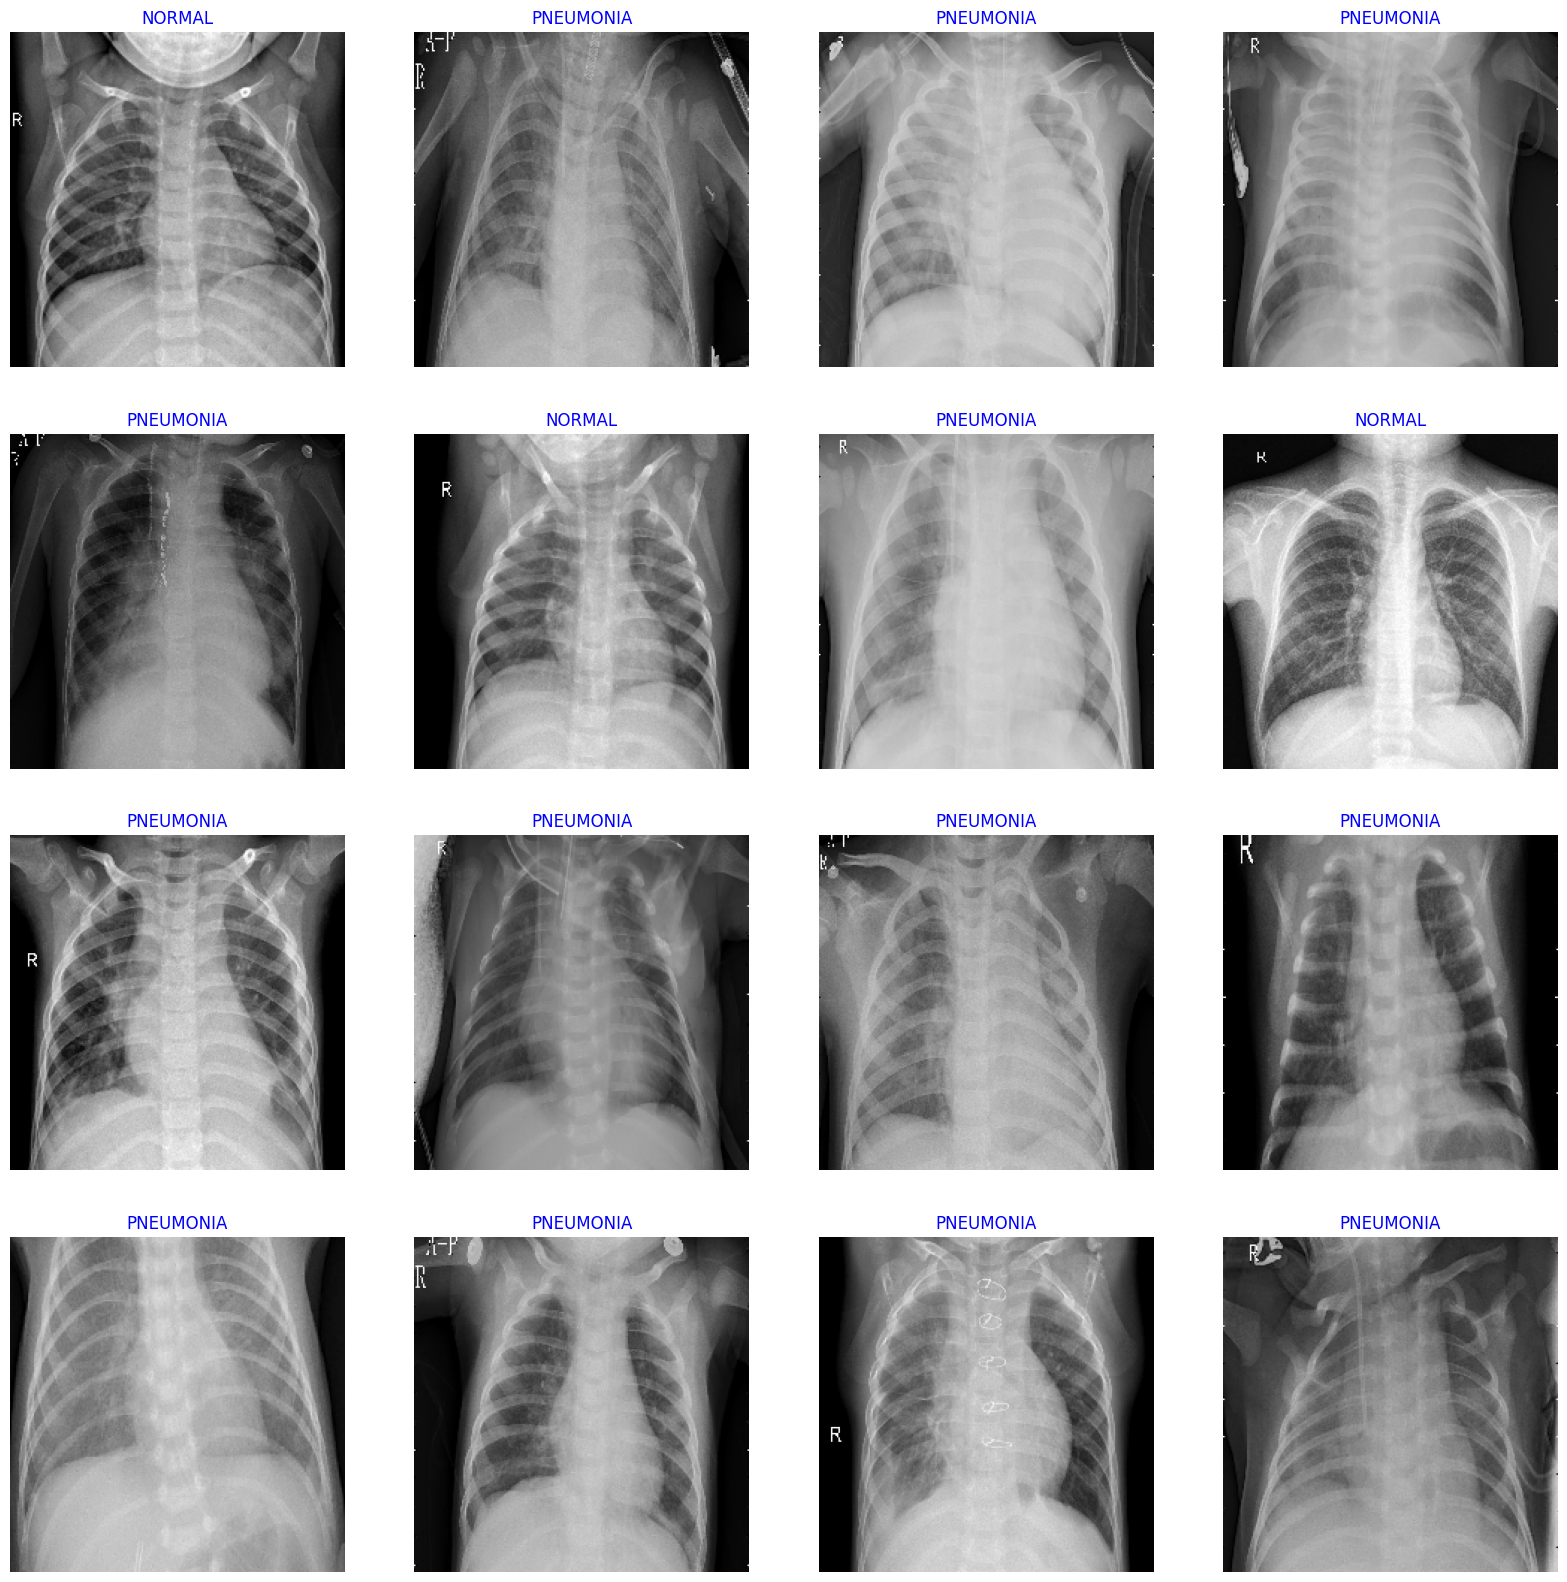

In [13]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    return model

model = create_cnn_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,262,434 (8.63 MB)

 Trainable params: 2,262,434 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [16]:
epochs = 15

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/15


I0000 00:00:1732075280.027366     102 service.cc:145] XLA service 0x7e8e98004d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732075280.027475     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732075280.027482     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/261 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.2656 - loss: 36.8113   

I0000 00:00:1732075296.761796     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


261/261 ━━━━━━━━━━━━━━━━━━━━ 102s 316ms/step - accuracy: 0.6920 - loss: 2.7239 - val_accuracy: 0.7414 - val_loss: 0.6235
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 0.7755 - loss: 0.5048 - val_accuracy: 0.8563 - val_loss: 0.3853
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.8670 - loss: 0.2971 - val_accuracy: 0.9157 - val_loss: 0.2346
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.9101 - loss: 0.2089 - val_accuracy: 0.9195 - val_loss: 0.2410
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step - accuracy: 0.9182 - loss: 0.1979 - val_accuracy: 0.8755 - val_loss: 0.2527
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.9315 - loss: 0.1640 - val_accuracy: 0.9195 - val_loss: 0.2108
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.9517 - loss: 0.1422 - val_accuracy: 0.9349 - val_loss: 0.1465
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.9469 - loss: 0.1352 - va

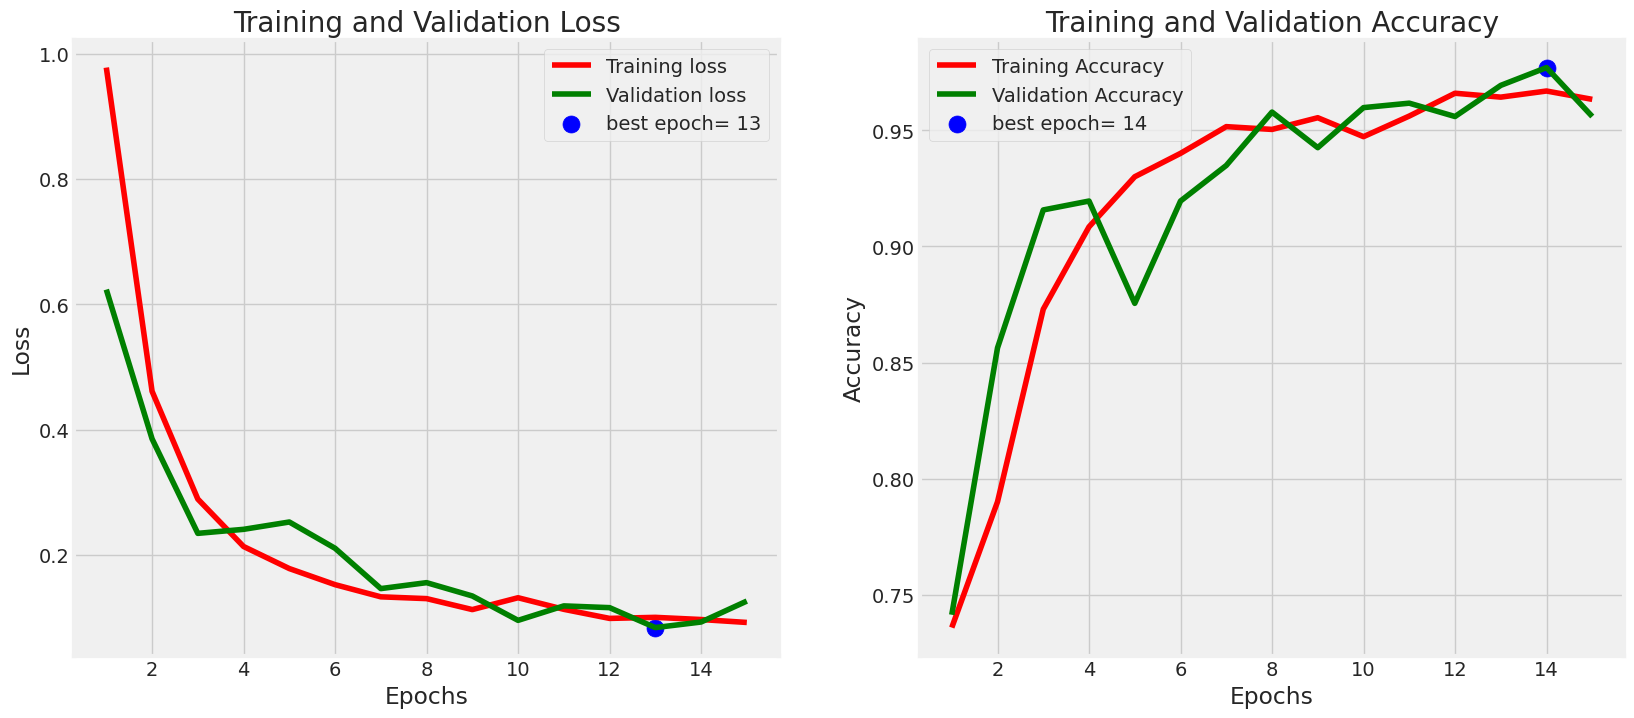

In [17]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [18]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - accuracy: 0.9561 - loss: 0.1252
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9557 - loss: 0.1299
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.9526 - loss: 0.1322
Train Loss:  0.12601551413536072
Train Accuracy:  0.9554170370101929
--------------------
Validation Loss:  0.12654715776443481
Validation Accuracy:  0.9559386968612671
--------------------
Test Loss:  0.14455851912498474
Test Accuracy:  0.9406130313873291


In [19]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1) 
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
cm


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step


array([[146,  10],
       [ 21, 345]])

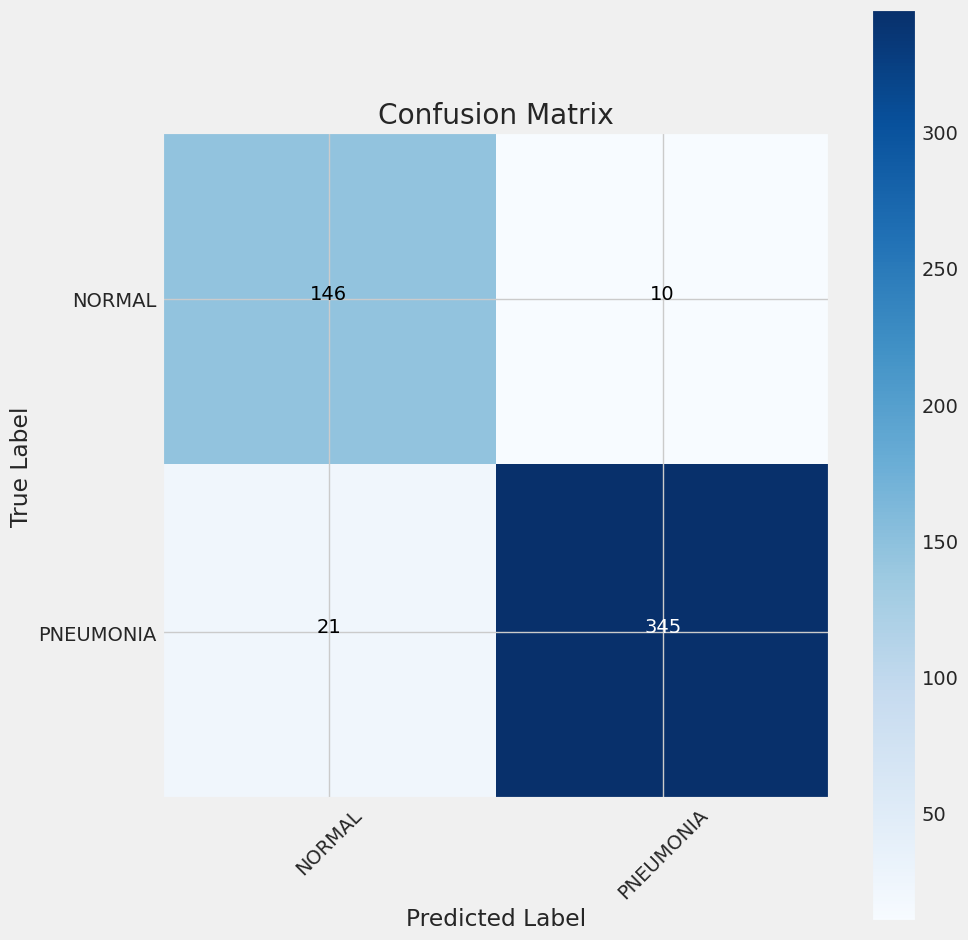

In [20]:

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
print(classification_report(test_gen.classes,y_pred,target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.87      0.94      0.90       156
   PNEUMONIA       0.97      0.94      0.96       366

    accuracy                           0.94       522
   macro avg       0.92      0.94      0.93       522
weighted avg       0.94      0.94      0.94       522



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


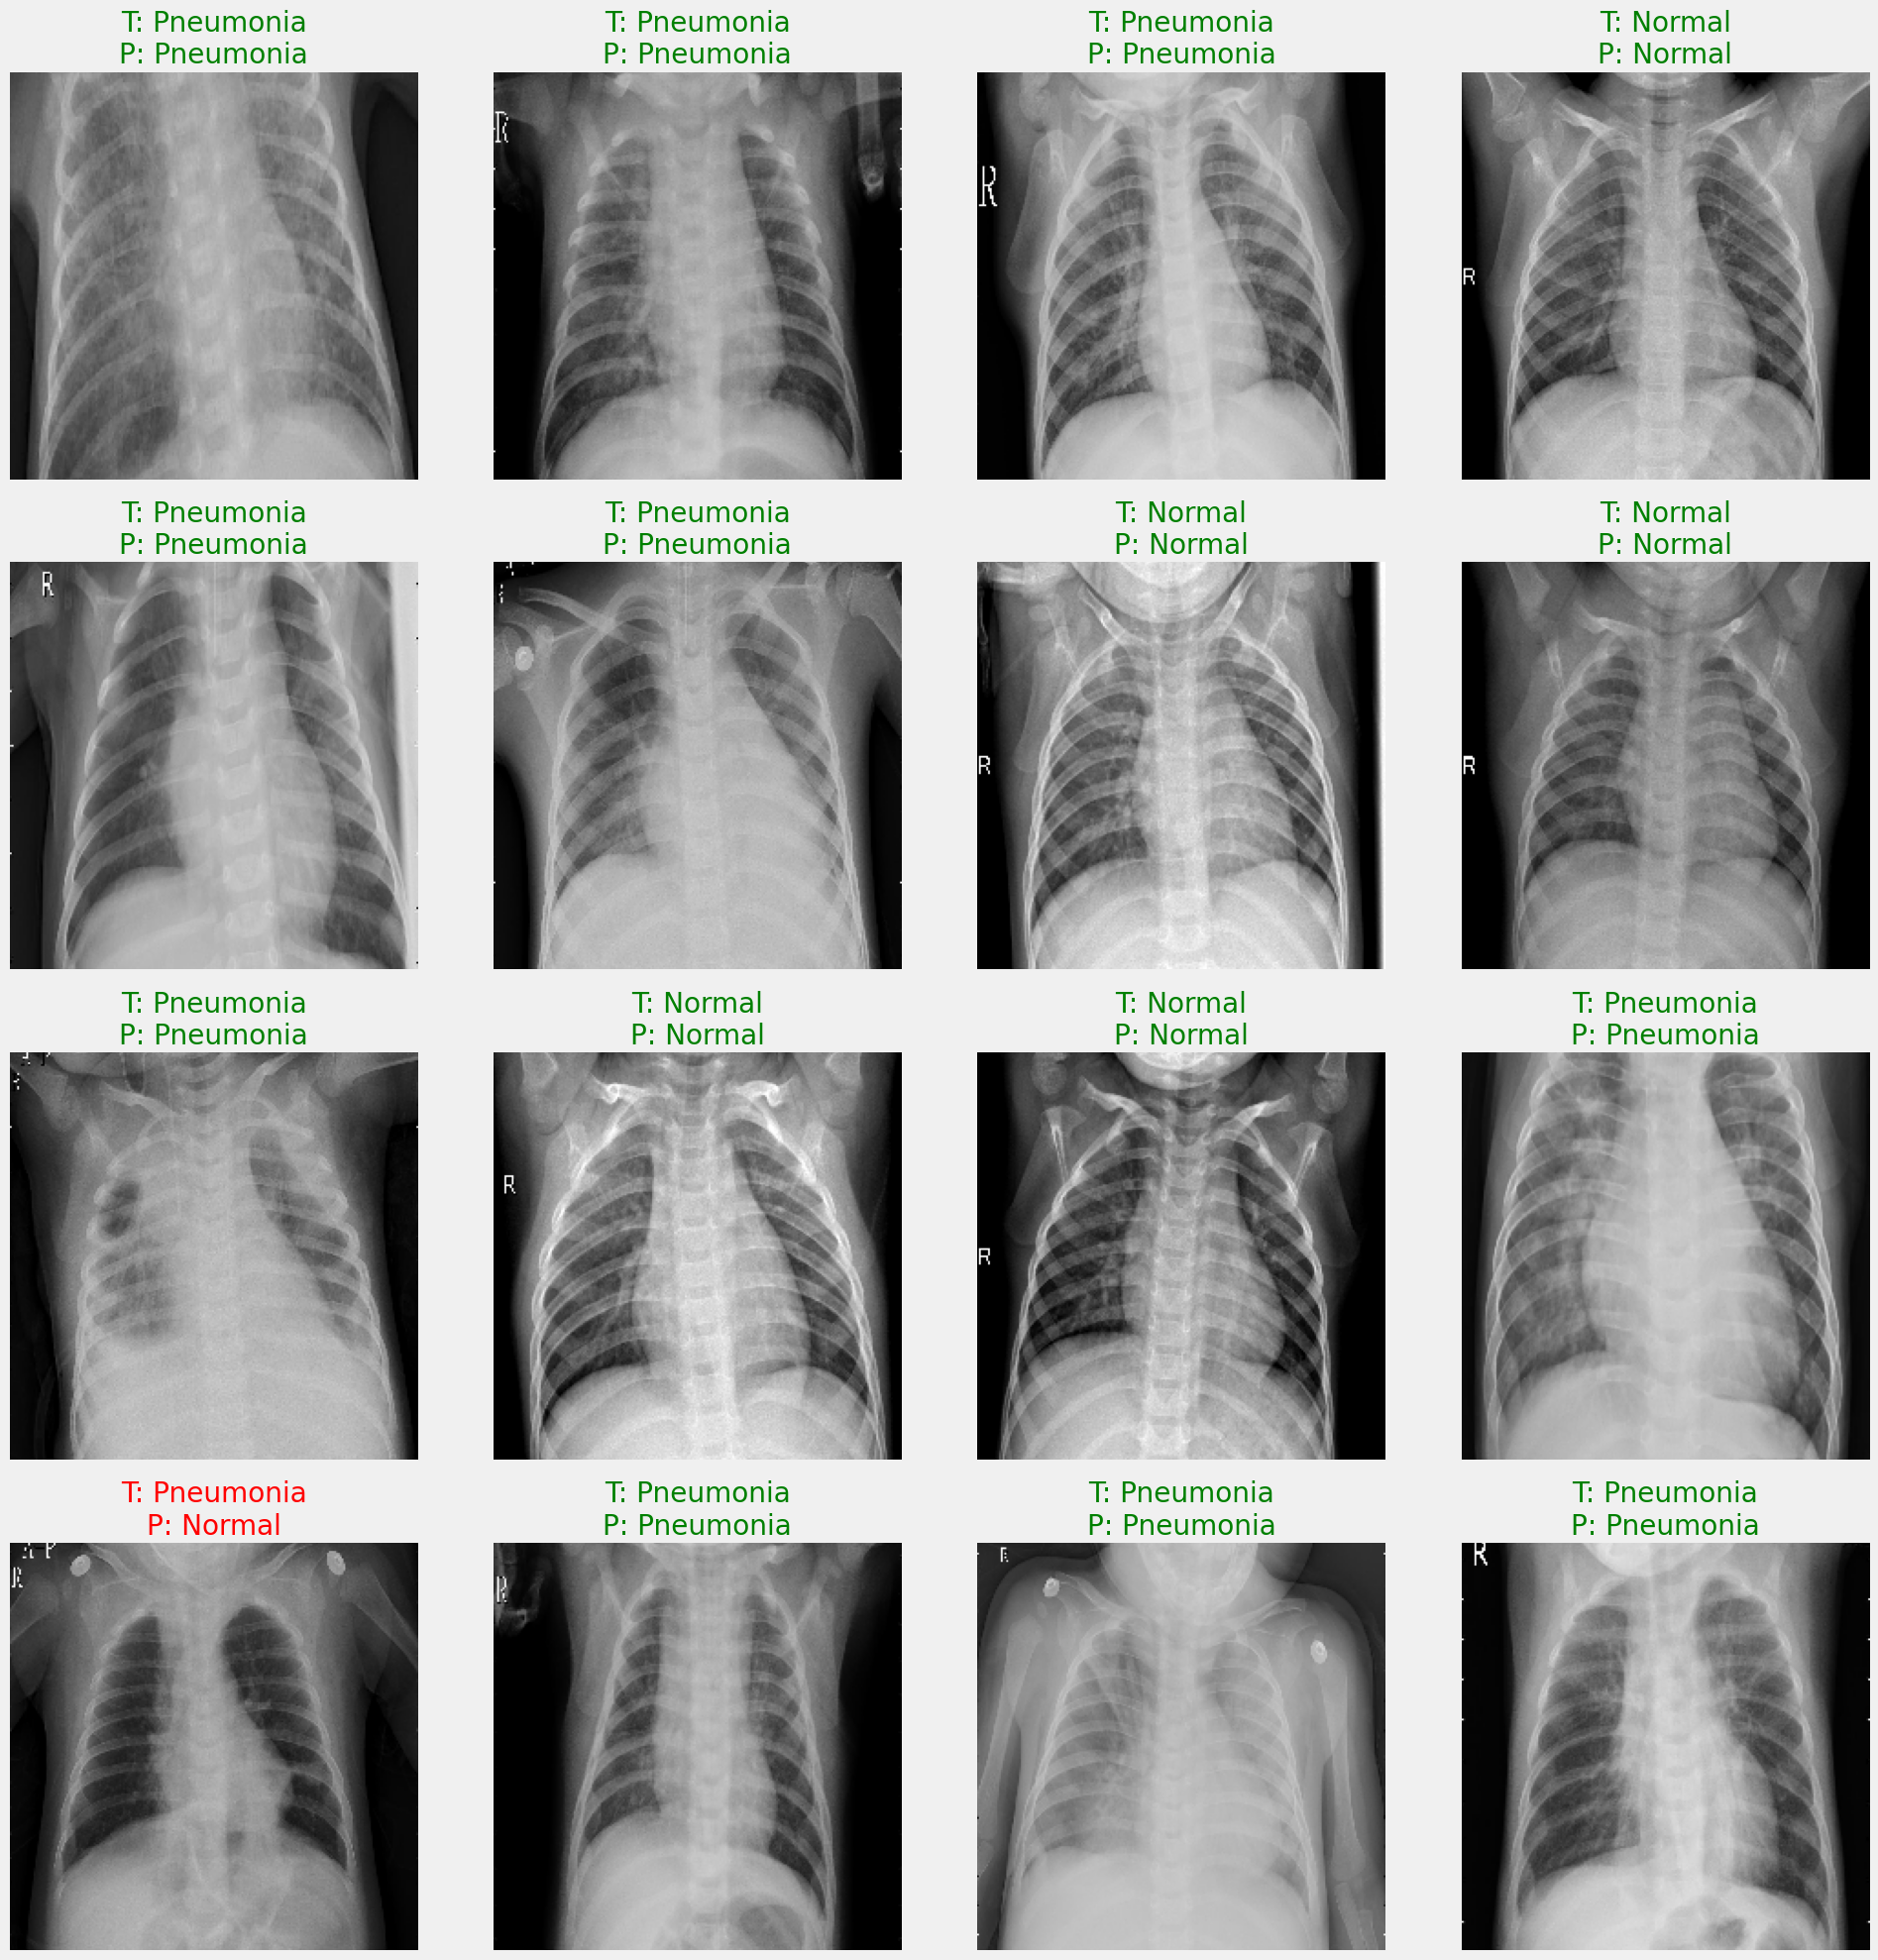

In [22]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ["Normal", "Pneumonia"]

x_test, y_true = next(test_gen)  
batch_size = x_test.shape[0] 
n_images = min(16, batch_size) 

x_test = x_test[:n_images]
y_true = y_true[:n_images]

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true_classes = np.argmax(y_true, axis=1) 

plt.figure(figsize=(20, 20))
for i in range(n_images):
    plt.subplot(4, 4, i + 1) 
    plt.imshow(x_test[i].astype("uint8"))  
    plt.axis("off")  
    true_label = class_names[y_true_classes[i]]
    pred_label = class_names[y_pred_classes[i]]
    plt.title(f"T: {true_label}\nP: {pred_label}", color=("green" if true_label == pred_label else "red"))

plt.tight_layout()
plt.show()
